<a href="https://colab.research.google.com/github/kasheena/Flower-Recognition-and-Classification-using-CNN/blob/main/ResNet50_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.chdir("/content/drive/My Drive/content")
!ls

flowers  resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5


In [2]:
import os
print(os.listdir('/content/drive/My Drive/content/flowers'))

['daisy', 'sunflower', 'rose', 'tulip', 'dandelion']


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import shutil
import matplotlib.pyplot as plt
%matplotlib inline 
import keras

from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import os
print(os.listdir('/content/drive/My Drive/content/flowers'))
# Any results you write to the current directory are saved as output.

['daisy', 'sunflower', 'rose', 'tulip', 'dandelion']


In [4]:
labels = os.listdir("/content/drive/My Drive/content/flowers")
num_classes = len(set(labels))
imagenet = '/content/drive/My Drive/content/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Create model
model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Do not train first layer (ResNet) as it is already pre-trained
model.layers[0].trainable = False
model.build(input_shape = (None, 32, 32, 3)
)
# Compile model
from tensorflow.keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 24,113,541
Trainable params: 525,829
Non-trainable params: 23,587,712
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [5]:
from tensorflow.keras.applications.vgg16 import preprocess_input
train_folder = '/content/drive/My Drive/content/flowers'

image_size = 224
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    horizontal_flip=True,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    validation_split=0.2)# set validation split

train_generator = data_generator.flow_from_directory(
    train_folder,
    target_size=(image_size, image_size),
    batch_size=24,
    class_mode='categorical',
    subset='training'
    )
validation_generator = data_generator.flow_from_directory(
    train_folder,
    target_size=(image_size, image_size),
    batch_size=24,
    class_mode='categorical',
    subset='validation'
    )

Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


In [6]:
NUM_EPOCHS = 20
EARLY_STOP_PATIENCE = 5

# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5',
                                  monitor = 'val_loss',
                                  save_best_only = True,
                                  mode = 'auto')
import math

fit_history = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    validation_data=validation_generator,
    validation_steps=10,
    epochs=NUM_EPOCHS,
    callbacks=[cb_checkpointer, cb_early_stopper])
model.load_weights("../working/best.hdf5")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
10/10 [==============================] - 182s 17s/step - loss: 1.7268 - accuracy: 0.4208 - val_loss: 0.7076 - val_accuracy: 0.7375
Epoch 2/20
10/10 [==============================] - 141s 15s/step - loss: 0.9576 - accuracy: 0.6542 - val_loss: 0.5889 - val_accuracy: 0.7833
Epoch 3/20
10/10 [==============================] - 121s 12s/step - loss: 0.7095 - accuracy: 0.7417 - val_loss: 0.4058 - val_accuracy: 0.8583
Epoch 4/20
10/10 [==============================] - 110s 11s/step - loss: 0.6443 - accuracy: 0.7542 - val_loss: 0.4116 - val_accuracy: 0.8458
Epoch 5/20
10/10 [==============================] - 100s 10s/step - loss: 0.5304 - accuracy: 0.8157 - val_loss: 0.3762 - val_accuracy: 0.8625
Epoch 6/20
10/10 [==============================] - 102s 10s/step - loss: 0.6316 - accuracy: 0.7750 - val_loss: 0.4458 - val_accuracy: 0.8292
Epoch 7/20
10/10 [==============================] - 100s 10s/step - loss: 0.5413 - accuracy: 0.8292 - val_loss: 0.3691 - val_accuracy: 0.8542
Epoch 

In [7]:
print(fit_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


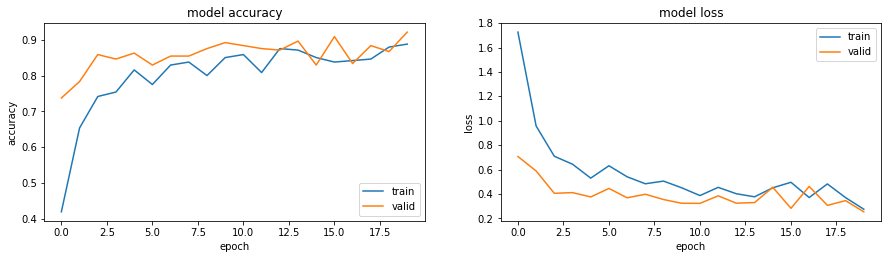

In [13]:
plt.figure(1, figsize = (15,8)) 

plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()